In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Segmentation

Mounted at /content/drive
/content/drive/MyDrive/Segmentation


In [32]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 9.3 MB/s eta 0:00:00


In [61]:
import pandas as pd 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import torch
from torchvision import datasets, models, transforms
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import requests
from PIL import Image
import random
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor
from skimage import io, transform
import random
import torch.nn.functional as Fun
from torchmetrics import Accuracy
from sklearn.metrics import classification_report, confusion_matrix,f1_score
import seaborn as sb

In [3]:
!ls

'Detecting Malaria'   Malaria.ipynb   model.pt	 models.pt


In [7]:
classes = ['Parasitized','Uninfected']
path = '/content/drive/MyDrive/Segmentation/Detecting Malaria/input/cell_images'

In [8]:
def create_data(path,classes):
  path_image,labels = [],[]
  for cls in classes:
    path_class = os.path.join(path, cls)
    for item in tqdm(os.listdir(path_class)):
      if item.split(".")[-1] in ['png','jpeg','jpg']:
        path_image.append(os.path.join(path_class,item))
        labels.append(cls)
      else:
        print(item)
        continue
  return path_image,labels

In [9]:
path_image,labels = create_data(path,classes)
temp = list(zip(path_image,labels))
random.shuffle(temp)
path_image,labels = zip(*temp)
path_image,labels = list(path_image), list(labels)

100%|██████████| 13782/13782 [00:00<00:00, 485111.60it/s]


Thumbs.db


100%|██████████| 13778/13778 [00:00<00:00, 570126.09it/s]

Thumbs.db


In [ ]:
path_image[:2]

In [ ]:
labels[:2]

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, img_labels, label,transform=None, target_transform=None):
        self.img_labels = img_labels
        self.transform = transform
        self.label = label
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.label[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return {"data":image, "label":label,'img_idx':idx,'path':img_path}

In [13]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels

array([1, 1, 0, ..., 1, 0, 0])

In [14]:
lengths = len(labels)
lengths

27558

In [15]:
img_labels_train = path_image[:int(lengths*0.9)]  
img_labels_test = path_image[int(lengths*0.9):]
labels = torch.tensor(labels).float()
labels_train = labels[:int(lengths*0.9)]
labels_test = labels[int(lengths*0.9):]

In [16]:
from torchvision import datasets, models, transforms
train_datasets = CustomImageDataset(img_labels_train,labels_train,
                                    transform=transforms.Compose([
                                               ToTensor(),
                                               transforms.Resize((224,224)),
                                               
                                           ]))
test_datasets = CustomImageDataset(img_labels_test,labels_test,
                                   transform=transforms.Compose([
                                               ToTensor(),
                                               transforms.Resize((224,224)),
                                               
                                           ]))
len(train_datasets),len(test_datasets)

(24802, 2756)

In [17]:
inverts = label_encoder.inverse_transform((labels.numpy()).astype(int))
target_dict = {}
labels_num = labels.numpy()
for i in range(len(labels.numpy())):
  target_dict[labels_num[i]] = inverts[i]

In [18]:
target_dict

{1.0: 'Uninfected', 0.0: 'Parasitized'}

0 torch.Size([3, 224, 224]) Uninfected /content/drive/MyDrive/Segmentation/Detecting Malaria/input/cell_images/Uninfected/C104P65ThinF_IMG_20150918_172053_cell_17.png
1 torch.Size([3, 224, 224]) Uninfected /content/drive/MyDrive/Segmentation/Detecting Malaria/input/cell_images/Uninfected/C92P53ThinF_IMG_20150821_151224_cell_201.png
2 torch.Size([3, 224, 224]) Parasitized /content/drive/MyDrive/Segmentation/Detecting Malaria/input/cell_images/Parasitized/C133P94ThinF_IMG_20151004_155721_cell_111.png
3 torch.Size([3, 224, 224]) Parasitized /content/drive/MyDrive/Segmentation/Detecting Malaria/input/cell_images/Parasitized/C179P140ThinF_IMG_20151127_153453_cell_188.png


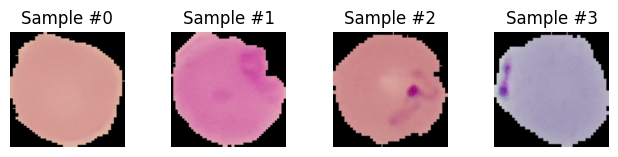

In [19]:
fig = plt.figure()

for i in range(len(train_datasets)):
    sample = train_datasets[i]

    print(i, sample['data'].shape,target_dict[float(sample['label'].numpy())],sample['path'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['data'].permute(1, 2, 0))

    if i == 3:
        plt.show()
        break

In [20]:
dataloaders_train = DataLoader(train_datasets, batch_size=16,
                        shuffle=True, num_workers=0)
dataloaders_test = DataLoader(test_datasets, batch_size=16,
                        shuffle=True, num_workers=0)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [22]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, len(classes))).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=1e-4,weight_decay=0.005)

In [24]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            running_loss = 0.0
            running_corrects = 0
            if phase == 'train':
                model.train()
                for ex in dataloaders_train:
                  inputs = ex['data'].to(device)
                  labels = ex['label']
                  labels = labels.type(torch.LongTensor).to(device)
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()
                  _, preds = torch.max(outputs, 1)
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)
                epoch_loss = running_loss / len(train_datasets)
                epoch_acc = running_corrects / len(train_datasets)
                print('Train : {} loss: {:.4f}, acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
    
            else:
                model.eval()
                for ex in dataloaders_test:
                  inputs = ex['data'].to(device)
                  labels = ex['label']
                  labels = labels.type(torch.LongTensor).to(device)
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  
                  _, preds = torch.max(outputs, 1)
                  prob = nn.Softmax(dim=1)(outputs) # prob
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)
                epoch_loss = running_loss / len(test_datasets)
                epoch_acc = running_corrects / len(test_datasets)
                print('Test : {} loss: {:.4f}, acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))

    return model

In [25]:
model_trained = train_model(model.to(device), criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
Train : train loss: 0.3226, acc: 0.8655
Test : validation loss: 0.2370, acc: 0.9057
Epoch 2/20
----------
Train : train loss: 0.2663, acc: 0.8920
Test : validation loss: 0.2217, acc: 0.9191
Epoch 3/20
----------
Train : train loss: 0.2528, acc: 0.9000
Test : validation loss: 0.2025, acc: 0.9220
Epoch 4/20
----------
Train : train loss: 0.2460, acc: 0.9012
Test : validation loss: 0.2112, acc: 0.9180
Epoch 5/20
----------
Train : train loss: 0.2427, acc: 0.9046
Test : validation loss: 0.2386, acc: 0.9028
Epoch 6/20
----------
Train : train loss: 0.2394, acc: 0.9055
Test : validation loss: 0.1886, acc: 0.9307
Epoch 7/20
----------
Train : train loss: 0.2292, acc: 0.9102
Test : validation loss: 0.1805, acc: 0.9365
Epoch 8/20
----------
Train : train loss: 0.2233, acc: 0.9120
Test : validation loss: 0.1803, acc: 0.9358
Epoch 9/20
----------
Train : train loss: 0.2280, acc: 0.9090
Test : validation loss: 0.1917, acc: 0.9311
Epoch 10/20
----------
Train : train loss: 0.2

In [26]:
torch.save(model,"models.pt")

In [34]:
mdl = torch.load("models.pt")

---------------------------Train Classification Report---------------------------


  0%|          | 0/1551 [00:00<?, ?it/s]<ipython-input-60-32c88eb45c0f>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(ex['label']).to(device)
100%|██████████| 1551/1551 [02:19<00:00, 11.11it/s]

              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93     12420
         1.0       0.94      0.92      0.93     12382

    accuracy                           0.93     24802
   macro avg       0.93      0.93      0.93     24802
weighted avg       0.93      0.93      0.93     24802

---------------------------Train Confusion Matrix---------------------------


<Axes: >

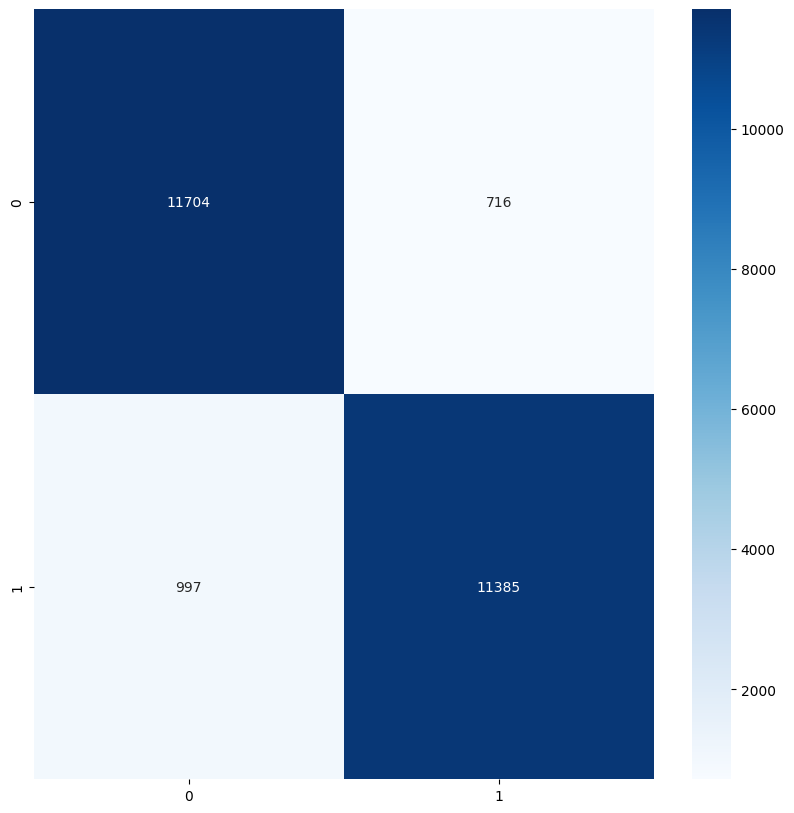

In [60]:
print('---------------------------Train Classification Report---------------------------')
mdl.train()
p, t = [], []

metric = Accuracy(task="multiclass", num_classes=2).to('cuda')
cst = 0
for ex in tqdm(dataloaders_train):
    x = ex['data'].to(device)
    y = torch.tensor(ex['label']).to(device)
    output = mdl(x).to(device)
    _, preds = torch.max(output, 1)
    p += output.argmax(dim=1).detach().cpu().tolist()
    t += y.detach().cpu().tolist()
    acc = metric(preds, y)
acc = metric.compute()
p, t = np.array(p), np.array(t)
print(classification_report(t, p))
print('---------------------------Train Confusion Matrix---------------------------')
plt.figure(figsize=(10,10))
sb.heatmap(confusion_matrix(t, p), cmap='Blues', annot=True, fmt='g')

---------------------------Test Classification Report---------------------------


  0%|          | 0/173 [00:00<?, ?it/s]<ipython-input-59-50347adc40a7>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(ex['label']).to(device)
100%|██████████| 173/173 [00:14<00:00, 11.83it/s]


              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      1361
         1.0       0.97      0.91      0.94      1395

    accuracy                           0.94      2756
   macro avg       0.94      0.94      0.94      2756
weighted avg       0.94      0.94      0.94      2756

---------------------------Test Confusion Matrix---------------------------


<Axes: >

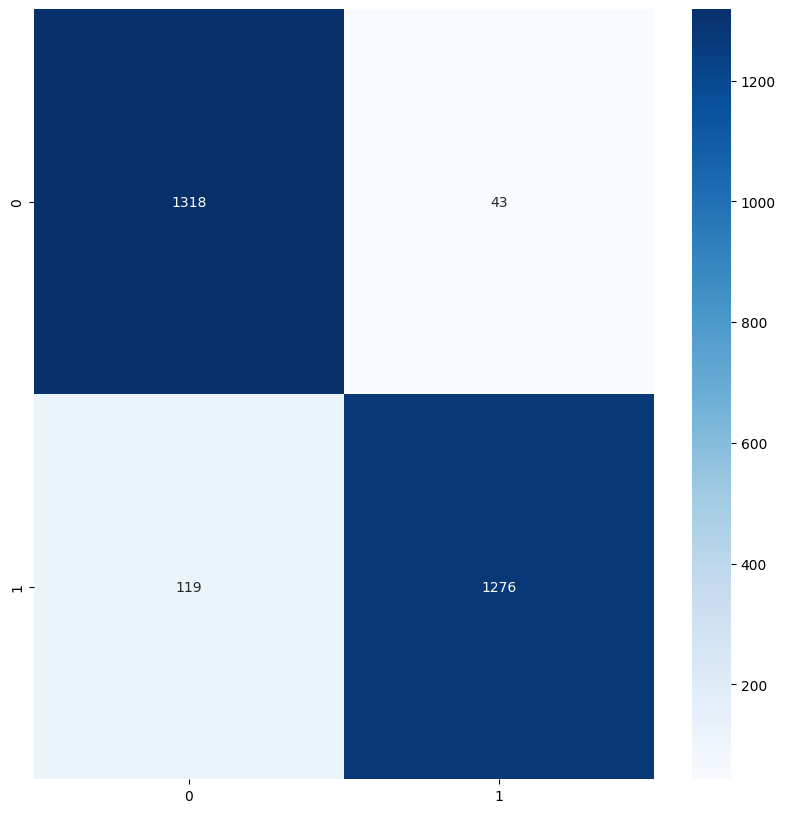

In [59]:
print('---------------------------Test Classification Report---------------------------')
mdl.eval()
p, t = [], []

metric = Accuracy(task="multiclass", num_classes=2).to('cuda')
cst = 0
for ex in tqdm(dataloaders_test):
    x = ex['data'].to(device)
    y = torch.tensor(ex['label']).to(device)
    output = mdl(x).to(device)
    _, preds = torch.max(output, 1)
    p += output.argmax(dim=1).detach().cpu().tolist()
    t += y.detach().cpu().tolist()
    acc = metric(preds, y)
acc = metric.compute()
p, t = np.array(p), np.array(t)
print(classification_report(t, p))
print('---------------------------Test Confusion Matrix---------------------------')
plt.figure(figsize=(10,10))
sb.heatmap(confusion_matrix(t, p), cmap='Blues', annot=True, fmt='g')